#### Experiment 1. Syntactic Dependency Analysis of gSCAN Demo Data
Based on current outline of gSCAN, we suspect that gSCAN is not grounded syntactically. This prevents models trained with gSCAN have true reasoning powers and true systematicity. All these codes are run against the original codebase released by authors of gSCAN (i.e., no new codes added in gSCAN), which ensures fairness.

In [18]:
import argparse
import logging
import os
import torch
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '../multimodal_seq2seq_gSCAN/'))
import random
import copy 

from seq2seq.gSCAN_dataset import GroundedScanDataset
from seq2seq.model import Model
from seq2seq.train import train
from seq2seq.predict import predict_and_save
from tqdm import tqdm, trange
from GroundedScan.dataset import GroundedScan

from typing import List
from typing import Tuple
from collections import defaultdict
from collections import Counter
import json
import numpy as np

from seq2seq.gSCAN_dataset import Vocabulary
from seq2seq.helpers import sequence_accuracy
from experiments_utils import *

FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.DEBUG,
                    datefmt="%Y-%m-%d %H:%M")
logger = logging.getLogger(__name__)
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter
use_cuda = True if torch.cuda.is_available() and not isnotebook() else False
device = "cuda" if use_cuda else "cpu"

if use_cuda:
    logger.info("Using CUDA.")
    logger.info("Cuda version: {}".format(torch.version.cuda))
    


train a model on demo data to make sure the pipeline is running correctly!

In [19]:
input_flags = vars(get_gSCAN_parser().parse_args(args=['--mode', 'train', 
                                           '--data_directory', '../multimodal_seq2seq_gSCAN/data/demo_dataset/', 
                                           '--output_directory', './syntactic_dependency-results/', 
                                           '--attention_type', 'bahdanau', 
                                           '--max_training_iterations', '1000',
                                           '--generate_vocabularies']))
# input_flags

{'mode': 'train',
 'output_directory': './syntactic_dependency-results/',
 'resume_from_file': '',
 'split': 'test',
 'data_directory': '../multimodal_seq2seq_gSCAN/data/demo_dataset/',
 'input_vocab_path': 'training_input_vocab.txt',
 'target_vocab_path': 'training_target_vocab.txt',
 'generate_vocabularies': True,
 'training_batch_size': 50,
 'k': 0,
 'test_batch_size': 1,
 'max_training_examples': None,
 'learning_rate': 0.001,
 'lr_decay': 0.9,
 'lr_decay_steps': 20000,
 'adam_beta_1': 0.9,
 'adam_beta_2': 0.999,
 'print_every': 100,
 'evaluate_every': 1000,
 'max_training_iterations': 1000,
 'weight_target_loss': 0.3,
 'max_testing_examples': None,
 'splits': 'test',
 'max_decoding_steps': 30,
 'output_file_name': 'predict.json',
 'simple_situation_representation': True,
 'cnn_hidden_num_channels': 50,
 'cnn_kernel_size': 7,
 'cnn_dropout_p': 0.1,
 'auxiliary_task': False,
 'embedding_dimension': 25,
 'num_encoder_layers': 1,
 'encoder_hidden_size': 100,
 'encoder_dropout_p': 0.3,

In [30]:
demo_data_path = os.path.join('../multimodal_seq2seq_gSCAN/data/demo_dataset/', 
                              "dataset.txt")
preprocessor = DummyGroundedScanDataset(demo_data_path, '../multimodal_seq2seq_gSCAN/data/demo_dataset/', 
                                        input_vocabulary_file="training_input_vocab.txt", 
                                        target_vocabulary_file="training_target_vocab.txt",
                                        generate_vocabulary=False,
                                        k=0)
# get a single example
demo_dataset = GroundedScan.load_dataset_from_file(demo_data_path, save_directory='./syntactic_dependency-results/', k=0)
raw_example = None
for _, example in enumerate(demo_dataset.get_examples_with_image('train', True)):
    raw_example = example
    break
single_example = preprocessor.process(raw_example)
# create the model
model = Model(input_vocabulary_size=preprocessor.input_vocabulary_size,
              target_vocabulary_size=preprocessor.target_vocabulary_size,
              num_cnn_channels=preprocessor.image_channels,
              input_padding_idx=preprocessor.input_vocabulary.pad_idx,
              target_pad_idx=preprocessor.target_vocabulary.pad_idx,
              target_eos_idx=preprocessor.target_vocabulary.eos_idx,
              **input_flags)
model = model.cuda() if use_cuda else model
_ = model.load_model("./syntactic_dependency-results/model_best.pth.tar")

2021-02-19 02:45 Initializing dummy gSCAN dataset for adverserial experiments...
2021-02-19 02:45 Loading vocabularies...
2021-02-19 02:45 Done loading vocabularies.


In [31]:
# regular input
print("in:", raw_example['input_command'])
print("true:", raw_example['target_command'])
# to feed this example, we need to modify the current pipeline a little bit
single_example = preprocessor.process(raw_example)
output = predict_single(single_example, model=model, 
                        max_decoding_steps=30, 
                        pad_idx=preprocessor.target_vocabulary.pad_idx, 
                        sos_idx=preprocessor.target_vocabulary.sos_idx,
                        eos_idx=preprocessor.target_vocabulary.eos_idx, 
                        device=device)
pred_command = preprocessor.array_to_sentence(output[3], vocabulary="target")
print("pred:", pred_command)

in: ['walk', 'to', 'a', 'red', 'circle']
true: ['turn right', 'walk']
pred: ['turn right', 'walk']


In [32]:
# corrupted input
corrupt_example = make_corrupt_example(raw_example)
print("in:", corrupt_example['input_command'])
print("true:", corrupt_example['target_command'])
# to feed this example, we need to modify the current pipeline a little bit
corrupt_single_example = preprocessor.process(corrupt_example)
corrupt_output = predict_single(corrupt_single_example, model=model, 
                                max_decoding_steps=30, 
                                pad_idx=preprocessor.target_vocabulary.pad_idx, 
                                sos_idx=preprocessor.target_vocabulary.sos_idx,
                                eos_idx=preprocessor.target_vocabulary.eos_idx, 
                                device=device)
corrupt_pred_command = preprocessor.array_to_sentence(corrupt_output[3], vocabulary="target")
print("pred:", corrupt_pred_command)

in: ['to', 'a', 'circle', 'red', 'walk']
true: ['turn right', 'walk']
pred: ['turn right', 'walk']


**wow!** even with very overfitted example (trained with very small demo), we can see that if we corrupt the input, the output command stays the same! this is a strong evidence that current gSCAN does not push neural models to acquire grounding skills over world knowledge at all.

#### Experiment 2. Syntactic Dependency Analysis of gSCAN Compositional Split Data (Actual Data in the gSCAN Paper)


In [6]:
input_flags = vars(parser.parse_args(args=['--mode', 'test', 
                                           '--data_directory', '../multimodal_seq2seq_gSCAN/data/compositional_splits/', 
                                           '--output_directory', './syntactic_dependency_compositional_splits-results/', 
                                           '--attention_type', 'bahdanau', 
                                           '--max_training_iterations', '200000']))
# input_flags

{'mode': 'test',
 'output_directory': './syntactic_dependency_compositional_splits-results/',
 'resume_from_file': '',
 'split': 'test',
 'data_directory': '../multimodal_seq2seq_gSCAN/data/compositional_splits/',
 'input_vocab_path': 'training_input_vocab.txt',
 'target_vocab_path': 'training_target_vocab.txt',
 'generate_vocabularies': False,
 'training_batch_size': 50,
 'k': 0,
 'test_batch_size': 1,
 'max_training_examples': None,
 'learning_rate': 0.001,
 'lr_decay': 0.9,
 'lr_decay_steps': 20000,
 'adam_beta_1': 0.9,
 'adam_beta_2': 0.999,
 'print_every': 100,
 'evaluate_every': 1000,
 'max_training_iterations': 200000,
 'weight_target_loss': 0.3,
 'max_testing_examples': None,
 'splits': 'test',
 'max_decoding_steps': 30,
 'output_file_name': 'predict.json',
 'simple_situation_representation': True,
 'cnn_hidden_num_channels': 50,
 'cnn_kernel_size': 7,
 'cnn_dropout_p': 0.1,
 'auxiliary_task': False,
 'embedding_dimension': 25,
 'num_encoder_layers': 1,
 'encoder_hidden_size': 

In [7]:
compositional_splits_data_path = os.path.join('../multimodal_seq2seq_gSCAN/data/compositional_splits/', 
                              "dataset.txt")
compositional_splits_preprocessor = DummyGroundedScanDataset(compositional_splits_data_path, 
                                        '../multimodal_seq2seq_gSCAN/data/compositional_splits/', 
                                        input_vocabulary_file="training_input_vocab.txt", 
                                        target_vocabulary_file="training_target_vocab.txt",
                                        generate_vocabulary=False,
                                        k=0)
# get a single example
compositional_splits_dataset = \
    GroundedScan.load_dataset_from_file(
        compositional_splits_data_path, 
        save_directory='./syntactic_dependency_compositional_splits-results/', 
        k=0)

2021-02-20 21:46 Initializing dummy gSCAN dataset for adverserial experiments...
2021-02-20 21:47 Loading vocabularies...
2021-02-20 21:47 Done loading vocabularies.


In [8]:
raw_example = None
for _, example in enumerate(compositional_splits_dataset.get_examples_with_image('test', True)):
    raw_example = example
    break
single_example = compositional_splits_preprocessor.process(raw_example)
# create the model
model = Model(input_vocabulary_size=compositional_splits_preprocessor.input_vocabulary_size,
              target_vocabulary_size=compositional_splits_preprocessor.target_vocabulary_size,
              num_cnn_channels=compositional_splits_preprocessor.image_channels,
              input_padding_idx=compositional_splits_preprocessor.input_vocabulary.pad_idx,
              target_pad_idx=compositional_splits_preprocessor.target_vocabulary.pad_idx,
              target_eos_idx=compositional_splits_preprocessor.target_vocabulary.eos_idx,
              **input_flags)
model = model.cuda() if use_cuda else model
_ = model.load_model("./syntactic_dependency_compositional_splits-results/model_best.pth.tar")

/dfs/user/wuzhengx/tool-chain/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [9]:
# regular input
print("in:", raw_example['input_command'])
print("true:", raw_example['target_command'])
# to feed this example, we need to modify the current pipeline a little bit
single_example = compositional_splits_preprocessor.process(raw_example)
output = predict_single(single_example, model=model, 
                        max_decoding_steps=30, 
                        pad_idx=compositional_splits_preprocessor.target_vocabulary.pad_idx, 
                        sos_idx=compositional_splits_preprocessor.target_vocabulary.sos_idx,
                        eos_idx=compositional_splits_preprocessor.target_vocabulary.eos_idx, 
                        device=device)
pred_command = compositional_splits_preprocessor.array_to_sentence(output[3], vocabulary="target")
print("pred:", pred_command)

in: ['push', 'a', 'green', 'small', 'circle']
true: ['turn left', 'turn left', 'walk', 'walk', 'turn right', 'walk', 'walk', 'walk']
pred: ['turn left', 'turn left', 'walk', 'walk', 'turn right', 'walk', 'walk', 'walk']


In [10]:
# corrupted input
corrupt_example = make_corrupt_example(raw_example)
print("in:", corrupt_example['input_command'])
print("true:", corrupt_example['target_command'])
# to feed this example, we need to modify the current pipeline a little bit
corrupt_single_example = compositional_splits_preprocessor.process(corrupt_example)
corrupt_output = predict_single(corrupt_single_example, model=model, 
                                max_decoding_steps=30, 
                                pad_idx=compositional_splits_preprocessor.target_vocabulary.pad_idx, 
                                sos_idx=compositional_splits_preprocessor.target_vocabulary.sos_idx,
                                eos_idx=compositional_splits_preprocessor.target_vocabulary.eos_idx, 
                                device=device)
corrupt_pred_command = compositional_splits_preprocessor.array_to_sentence(corrupt_output[3], vocabulary="target")
print("pred:", corrupt_pred_command)

in: ['push', 'a', 'small', 'green', 'circle']
true: ['turn left', 'turn left', 'walk', 'walk', 'turn right', 'walk', 'walk', 'walk']
pred: ['turn left', 'turn left', 'walk', 'walk', 'turn right', 'walk', 'walk', 'walk']


#### Experiment 3. Systematically look at the effect with full gSCAN dataset

Performance drops with permuted inputs which kept the same semantics

**Hypothesis** If the model do grounded language reasonings syntactically, we should see performance kept in the same level across all test splits. If not, it means model does not reason about the input command, and mostly likely is just doing some pattern matching.

Will the prediction change if we randomly swap words in the inputs?

**Hypothesis** If the model output does not change for the majority of cases, it is another strong proof of the model being lacking of systematicity.

Text(0, 0.5, 'Frequency')

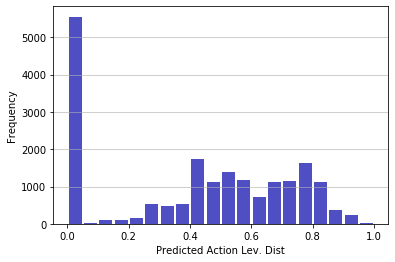

In [111]:
n, bins, patches = plt.hist(x=pred_levDs, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Predicted Action Lev. Dist')
plt.ylabel('Frequency')